In [2]:
"""

Spatial interpolation of copper and cobalt concentration measurements 
                    from geochemical soil survey

                       Valère Lambert, May 2024

    Predictions based on Kriging with a circular semivariogram model

"""

import numpy as np
from numpy.linalg import inv
import scipy as sp
import scipy.optimize
from scipy.spatial.distance import squareform
from scipy.interpolate import RBFInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import cm
import pandas as pd

In [3]:
# Load data
filename= 'soil_geochemistry.csv'
data = pd.read_csv(filename)
data.head(10)

,Cu,Co,x,y,units
0,1005.545921,282.993340,99.901372,14.761337,ppm
1,867.986487,234.174761,55.263516,1.302959,ppm
2,96.807653,NaN,65.098168,85.424006,ppm
3,2.551491,0.346934,3.332742,72.062110,ppm
4,2374.160259,NaN,85.222209,25.060859,ppm
5,0.007068,0.001201,66.921381,97.873821,pct
6,0.005288,0.000676,67.398791,78.276039,pct
7,426.209268,70.920538,2.792840,35.296034,ppm
8,0.100882,0.011337,77.363267,76.113519,pct
9,3679.598922,721.787212,84.548477,63.849979,ppm


In [4]:
# Quality control on data 
# 1. Remove NaN entries from Cu and Co concentration arrays
# 2. Assign proper concentration amplitudes given ppm vs pct units

# Extract spatial coordinates for 2-D position vector
pos = data[['x','y']].values

# Extract Cu and Co concentrations
cu_raw = data[['Cu']].values
co_raw = data[['Co']].values

# Apply unit amplitude to concentration values
units = data[['units']].values
unit_Dict = {'ppm':1.e-6,'pct':1.e-2}

# We will work in ppm
ppm_unit = 1.e-6  
for l in range(units.size):
    factor = unit_Dict.get(units[l][0])
    cu_raw[l] = cu_raw[l]*factor/ppm_unit
    co_raw[l] = co_raw[l]*factor/ppm_unit
    
# Check that the concentration values are positive and not NaNs
valid_co = np.argwhere(co_raw==np.absolute(co_raw))
valid_cu = np.argwhere(cu_raw==np.absolute(cu_raw))

# Define new concentration and position arrays for acceptable data
co_con = co_raw[valid_co[:,0]]
co_pos = pos[valid_co[:,0],:]

cu_con = cu_raw[valid_cu[:,0]]
cu_pos = pos[valid_cu[:,0],:]

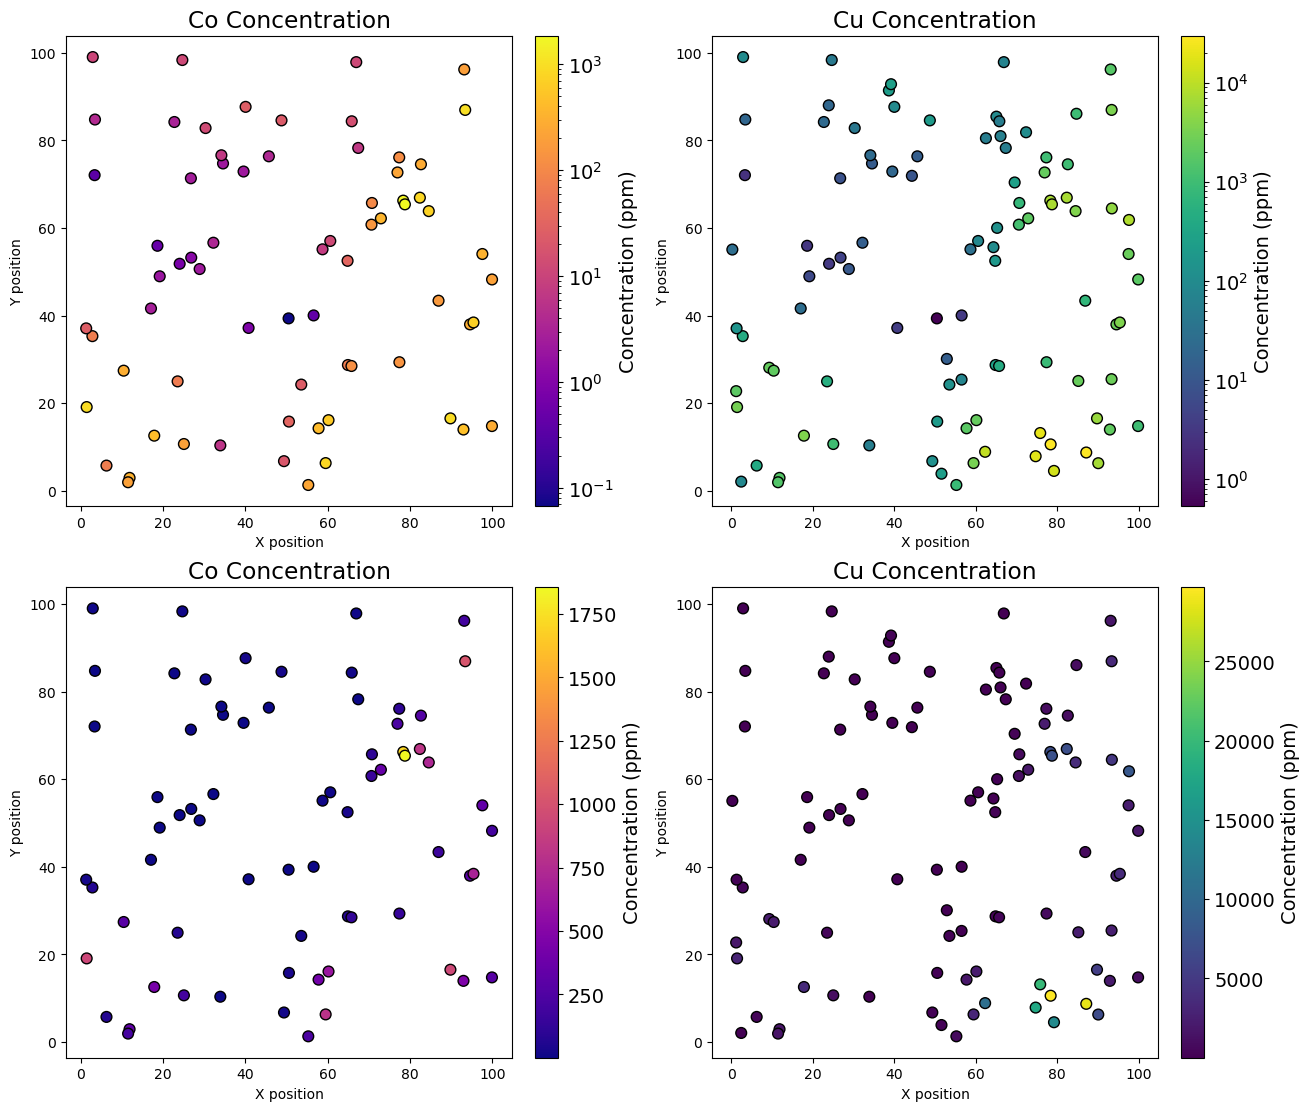

In [5]:
# Create an x-y scatter plot colored by concentration of Cu and Co
fig,ax = plt.subplots(2,2,constrained_layout=True) 
fig.tight_layout
fig.set_size_inches(13,11)

# setting font size to 14
plt.rcParams.update({'font.size': 14})
msize = 60

# Plot Co concentation data (ppm)
# Log-scale
ax1 = ax[0,0].scatter(co_pos[:,0],co_pos[:,1],s=msize,c=co_con,cmap=cm.plasma,
                   norm=colors.LogNorm(vmin=co_con.min(), vmax=co_con.max()),linewidths=1,edgecolors='k')
ax[0,0].set_xlabel('X position')
ax[0,0].set_ylabel('Y position')
ax[0,0].set_title('Co Concentration')
cb1 = plt.colorbar(ax1,ax=ax[0,0])  
cb1.set_label('Concentration (ppm)')

# Lin-scale
ax3 = ax[1,0].scatter(co_pos[:,0],co_pos[:,1],s=msize,c=co_con,cmap=cm.plasma,linewidths=1,edgecolors='k')
ax[1,0].set_xlabel('X position')
ax[1,0].set_ylabel('Y position')
ax[1,0].set_title('Co Concentration')
cb3 = plt.colorbar(ax3,ax=ax[1,0])  
cb3.set_label('Concentration (ppm)')

# Plot Cu concentation data (ppm)
# Log-scale
ax2 = ax[0,1].scatter(cu_pos[:,0],cu_pos[:,1],s=msize,c=cu_con,cmap=cm.viridis,
                   norm=colors.LogNorm(vmin=cu_con.min(), vmax=cu_con.max()),linewidths=1,edgecolors='k')
ax[0,1].set_xlabel('X position')
ax[0,1].set_ylabel('Y position')
ax[0,1].set_title('Cu Concentration')
cb1 = plt.colorbar(ax2,ax=ax[0,1])  
cb1.set_label('Concentration (ppm)')

# Lin-scale
ax4 = ax[1,1].scatter(cu_pos[:,0],cu_pos[:,1],s=msize,c=cu_con,cmap=cm.viridis,linewidths=1,edgecolors='k')
ax[1,1].set_xlabel('X position')
ax[1,1].set_ylabel('Y position')
ax[1,1].set_title('Cu Concentration')
cb4 = plt.colorbar(ax4,ax=ax[1,1])   
cb4.set_label('Concentration (ppm)')

Text(0, 0.5, 'Count')

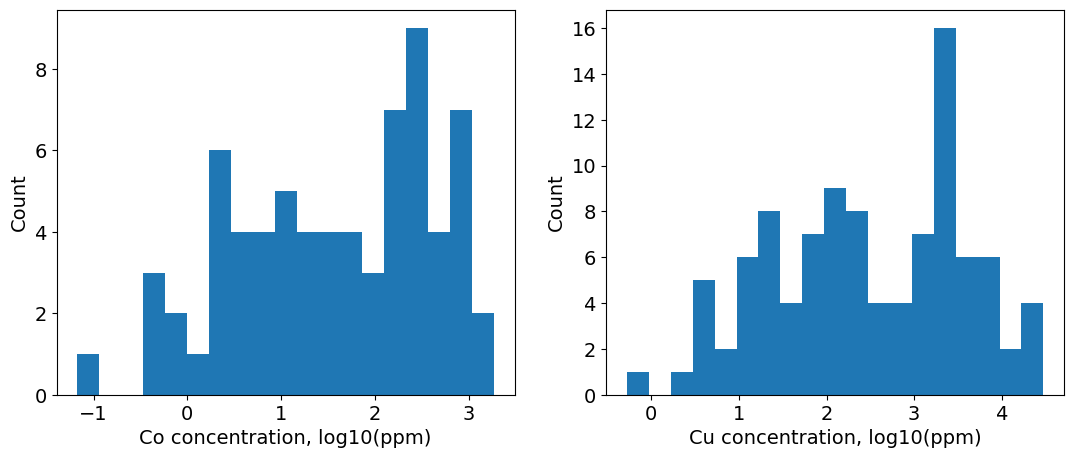

In [6]:
# Concentrations are non-negative so let's consider log-normal priors

# Let us check if our data is reasonably log-normal (not perfect but will proceed)
co_dat = np.log10(co_con)
cu_dat = np.log10(cu_con)

fig,ax = plt.subplots(1,2,figsize=[13,5])
fig.tight_layout
ax[0].hist(co_dat ,bins=np.linspace(np.min(co_dat ),np.max(co_dat ),20))
ax[0].set_xlabel('Co concentration, log10(ppm)')
ax[0].set_ylabel('Count')

ax[1].hist(np.log10(cu_con),bins=np.linspace(np.min(cu_dat ),np.max(cu_dat ),20))
ax[1].set_xlabel('Cu concentration, log10(ppm)')
ax[1].set_ylabel('Count')

In [7]:
"""

  Define useful functions for calculating distances between points
            and constructing semivariograms for the data

"""
def Edist(pos1,pos2):
    """ Calculate the Euclidean distance between two points
    
    In: pos1, po2: 2x1 arrays with (x,y) spatial coordinates
    Out: scalar Euclidean distance between points
    """ 

    # assert that the position arrays have 2 coordinates (x,y)
    assert(np.size(pos1)==2 & np.size(pos2)==2), 'position arrays must have 2 coordinates'
    return np.sqrt( (pos1[0]-pos2[0])**2 + \
                    (pos1[1]-pos2[1])**2)

def getDistanceArray(x,y,pos):
    """  Calculate the Euclidean distance between sets of
                     points within an array

    In: x,y: N x 1  spatial coordinates arrays (for interpolated grid)
        pos: N x 2 array with (x,y) spatial coordinates (for sampled data)

    Out: distij: NxX array with Euclidean distance between each point
    """

    # Assert that observation position array has 2 coordinates and
    # that the x,y,pos arrays have the same length
    assert(np.size(pos,1)==2), 'position array must have 2 coordinates'
    assert(np.size(x)==np.size(pos,0) & np.size(y)==np.size(pos,0)), 'position arrays must have same length'
    
    ncells = np.size(x)
    npoints = np.size(pos,0)
    distij = np.zeros([ncells,npoints])
    for i in range(ncells):
        for j in range(npoints):
            distij[i,j] = Edist([[x[i]], [y[i]]],pos[j,:])[0][0]
    return distij
        
def semivar(c1,c2):
    """ Calculate the semivariance between two obs. points
           (i.e. half the squared difference in values)   
    """ 
    return 0.5*(c2-c1)**2

def getDifferences(pos,conc):
    """ Calculate the distance and semivariance for each pair
        observations as well as the nearest neighbor for each point 

    In: pos: Nx2 array of position coordinates (x,y) for data 
        conc: Nx1 array of data values (concentrations)

    Out: dist: Mx1 array of Euclidean distances between unique pairs of points
         gamma: Mx1 array of semivariance between unique pairs of points
         nnb: Nx1 array with Euclidean distance to nearest neighbor for each obs. point
    """
    
    # Assert that the position array has 2 coordinates (x,y)
    assert(np.size(pos,1)==2),  'position array must have 2 coordinates'
    
    npoints = np.size(pos,0)
    npairs = 0

    # calculate number of unique pairs to predefine arrays
    for i in range(npoints):
        npairs += i

    index = 0
    dist = np.zeros(npairs)         # distance between points
    gamma = np.zeros(npairs)        # semivariance
    nnb = 1.e12*np.ones(npoints)    # distance to nearest neighbor
    for i in range(npoints):
        for j in range(i+1,npoints):
            # Calculate the Euclidean distance between points
            dist[index] = Edist(pos[i,:],pos[j,:])
        
            # Calculate the semivariance
            gamma[index] = semivar(conc[i][0],conc[j][0])
           
            # Find distance to nearest-neightbor for each point
            if dist[index] < nnb[i]:
                nnb[i] = dist[index]
            if dist[index] < nnb[j]:
                nnb[j] = dist[index]
            
            index+=1
        
    return dist,gamma,nnb

def binSemivariance(fact,nnb,h,gamma):
    """ Determine binning and occupants for binned semivariogram

        In: fact:  scaling factor for bin size
            nnb:   Nx1 array with Euclidean distance to nearest neighbor for each obs. point
            h:     Mx1 array with Euclidean distance between points
            gamma: Mx1 array of semivariance between unique pairs of points

        Out: max_dist:  scalar maximum distance between obs. points
             bins:      rx1 array of bins for semivariogram
             bin_count: rx1 array with number of occupants in each bin
             Gamma:     rx1 array with binned semivariance
    """
    # Determine a lag size for binning using the average distance to nearest neighbor (multiplied by factor fact)
    avg_nn = fact*np.mean(nnb)
    
    max_dist = np.max(h) # max distance between points

    # Determine number of bins and create bins
    nbins = int(np.ceil(max_dist/avg_nn))
    bins = np.linspace(0,max_dist,num=nbins)

    # Get bin indices for data
    bins_i = np.digitize(h,bins)
    
    # Determine semivariance for each lag bin (Matheron estimator)
    # by summing contributions from occupants for each bin
    Gamma = np.zeros(nbins)
    bin_count = np.zeros(nbins)
    
    for i in range(nbins):
        indices = np.where(bins_i == i)  # find occupants of the bin
        bin_count[i] = len(indices[0])
        if bin_count[i] > 0:
            Gamma[i] =  np.sum(gamma[indices])/ float(len(indices[0]))
    
    return max_dist, bins, bin_count, Gamma

def Semivariogram(nnb,h,gamma,nmin,rel_fact):
    """
    Construct semivariogram and determine reasonable binning such that 
    each bin has sufficient occupants (nmin)
    => loops over and calls "binSemivariance" function

    In: nnb:       Nx1 array with Euclidean distance to nearest neighbor for each obs. point
        h:         Mx1 array with Euclidean distance between points
        gamma:     Mx1 array of semivariance between unique pairs of points
        nmin:      scalar, minimum number of occupants per bin
        rel_fact:  Reliability factor determining the spatial scale over which fit will be performed

    Out: hmax:    scalar, maximum distance between points
         hrel:    scalar, reliability scale over which fit will be performed
         bins:    rx1 array of bins for semivariogram
         bc:      rx1 array with number of occupants in each bin      
         Gamma_b: rx1 array with binned semivariance

    """
    criterion = True
    
    # Start by assigning bin size to average distance between nearest neighbors,
    # incrementally increase until bins have sufficient occupants (nmin)
    fact0 = 1.0     # prefactor for changing bin spacing
    dfact = 0.01    # bin spacing increment
    iter = 0
    while criterion:
        fact = fact0 + iter*dfact

        # Determine binning for semivariance 
        hmax, bins, bc, Gamma_b = binSemivariance(fact,nnb,h,gamma) 
        hrel = rel_fact*hmax

        # Check to make sure bin counts satisfy minimum occupant criterion
        criterion = np.any((bc < nmin) & (bins > 0) & (bins < hrel))
        iter += 1
    return hmax,hrel,bins,bc,Gamma_b

In [8]:
# Let us perform some unit tests

# test EDist
p1 = [0,0]
p2 = [1,1]
print(Edist(p1,p2))

p1 = 0
p2 = 2
print(Edist(p1,p2))

1.4142135623730951


AssertionError: position arrays must have 2 coordinates

In [12]:
# Fitting functions for experimental variatiograms based on ArcGIS Pro functions 
# https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-kriging-works


def ModelEval(x,model,p1,p2,p3):
    """ Calculate predicted value at position x given specified model and params
    
        In: 
        x: single position value
        model: string specifying fit function
        p1,p2,p3: model parameters (conveniently each of these models take 3 parameters - should generalize for future)

        Out: 
        out: single prediction value
    """
    match model:
        # Bounded Linear fit model
        case "Linear":
            if x <= p3:
                return p1 + (p2-p1)*(x/p3)
            else:
                return p2

        # Exponential fit model
        case "Exponential":
            return p1 + (p2-p1)*(1.0 - np.exp(- x/p3 ))

        # Spherical fit model
        case "Spherical":
            if x < p3:
                return p1 + (p2-p1)*(1.5*(x/p3) - 0.5*(x/p3)**3 )
            else:
                return p2

        # Gaussian fit model
        case "Gaussian":
            return p1 + (p2-p1)*(1.0 - np.exp(-(x/p3)**2) )

        # Circular fit model
        case "Circular":
            if x < p3:
                return p1 + (2/np.pi)*(p2-p1)* \
                ( x/p3 *np.sqrt(1 - (x/p3)**2)+np.arcsin(x/p3) )
            else:
                return p2

        # Power law fit model
        case "Power":
            return p1+(p2-p1)*x**p3

        # Not a recognized model
        case _:
            print("Not a supported/valid fit model")    

def fitModel(x,model,p1,p2,p3):
    """ Construct predictions for positions x for given fit model with params 
        => used in optimization to determine appropriate params given model and data 
        
        In: 
        x: N x 1 array
        model: string specifying fit function
        p1,p2,p3: model parameters (conveniently each of these models take 3 parameters - should generalize for future)

        Out: 
        out: N x 1 prediction array
    """
    out = np.zeros(x.size)
    for i in range(x.size):
        out[i] = ModelEval(x[i],model,p1,p2,p3)
    return out

def performFits(x,y,models,hrel):
    """
    Loop over set of model functions and perform fit to data vector y 

    In: 
    x,y:  :  N x 1 arrays input independent and dependent variables, respectivel
    models:  q x 1 array of strings specifying fit functions
    hrel:   scalar specifying range over which fit will be performed

    Out:
    fitparams: q x 3 array of fit paramerers
    cvparams:  q x 3 array of covariance for fit parameters
    err:       q x 1 array of standard error from fits
    ll:        q x 1 array of log-likelihood for fits

    """
    # All of the fit functions we will try will only have 3 parameters (convenient) 
    # but should generalize these functions in the future
    fitparams = np.zeros([len(models),3])
    cvparams = np.zeros([len(models),9])
    err = np.zeros(len(models))
    ll = np.zeros(len(models))
    # Loop over fit models
    for i in range(len(models)):

        # Assigned initial guesses and fit bounds
        if models[i]=="Power":
            p0 =  (2,1,1.5)
            mybounds = ((0,0,0),(np.inf,np.inf,2))
        else:
            p0 = (0,1,0.5*hrel)
            mybounds = ((0,0,0),(1.e-6,np.inf,np.inf))

        # perform fit
        params, cv = scipy.optimize.curve_fit(lambda x, p1, p2, p3: fitModel(x,models[i],p1,p2,p3),x,y,\
                                          p0,bounds=mybounds)

        # Calculate prediction from best fit
        bestpred = fitModel(x,models[i],params[0],params[1],params[2])

        # Calculate standard error
        err[i] = np.sqrt( sum( (bestpred - y)**2) / np.size(x))
        n = np.size(x)
        ll[i] = -0.5*n*np.log(2*np.pi) - 0.5*n*np.log(err[i]**2) - \
                0.5*(1/err[i]**2)*np.sum((bestpred-y)**2)
        fitparams[i,:] = params
        cvparams[i,:] = cv.flatten()
        
    return fitparams,cvparams,err,ll
    
def ConstructKrigingSystem(pos,vals,model,params):
    """ Construct Kriging matrix M of semivariances
        plus 1s for constraint of unbiased estimator   

    Goals of kriging are to produce an estimator Y_hat that is 1) unbiased
    and 2) for which the estimation variance is minimized

    For (1) we want the sum of the weights sum w_i = 1
        
    In: 
    pos:    Nx2 position array
    model:  string specifying model function
    params: nparam x 1 array of model parameter values
    
    Out:
    M: (N+1) x (N+1) matrix for Kriging system
    """                       
    # Assert number of fit parameters = 3
    assert(np.size(params)==3),  'fit model requires 3 parameters'
    # Assert that the position array has 2 coordinates (x,y)
    assert(np.size(pos,1)==2),  'position array must have 2 coordinates'
                           
    # Loop over observation points, construct matrix B of semivariance predictions
    npoints = np.size(pos,0)
    B = np.zeros([npoints,npoints])
    for i in range(npoints):
        for j in range(i,npoints):
            # Calculate distance between points
            distij = Edist(pos[i,:],pos[j,:])

            # predicted semivariance given model
            gamma_pred = ModelEval(distij,model,params[0],params[1],params[2])
            B[i,j] = gamma_pred
            B[j,i] = B[i,j]

    # We want to ensure that the sum of the kriging weights add up to 1
    # to determine an unbiased estimator
    # Modify our matrix:
    lastrow = np.ones(np.size(B,0))
    lastcol = np.ones((np.size(B,1)+1,1))
    lastcol[-1] = 0  
    M = np.concatenate((B,[lastrow]),axis=0)
    M = np.concatenate((M,lastcol),axis=1)
    return M

def KrigingPrediction(pos,con,x_i,y_i,M,model,params):
    """
    Calculate predicted values and their uncertainty at interpolation 
             points using kriging with specified model 
    
    In: 
    pos:     N x 2 array of position (x,y) coordinates for obs. points
    con:     N x 1 array of values (concentrations) for obs. points
    x_i,y_i: Q x 1 arrays of position coordinates for prediction points
    M:       (N+1) x (N+1) matrix for Kriging system
    model:   string specifying model function
    params:  3x1 array of model fit parameters

    Out:
    pred:  Q x 1 array of predicted concentration values on grid 
    var:   Q x 1 array with kriging prediction errors
    """
# Loop over prediction grid points
# Calculate the distance to each data point and corresponding semivariance prediction using model
# Determine kriging weights and prediction
# Calculate kriging variance at point
    # Assert that the model is supplied 3 parameters
    assert(np.size(params)==3), 'fit model requires 3 parameters'
    
    ncells = x_i.size
    npoints = np.size(con)
    pred = np.zeros(ncells)
    var = np.zeros(ncells)

    # Calculate inverse of kriging matrix
    Mi = inv(M)

    # Loop over prediction grid points
    for i in range(ncells):
        b = np.zeros(npoints+1)
        b[-1] = 1 

        # Loop over observation points
        for j in range(npoints):
            
            # Calculate distance between grid point and each observation point
            distij = Edist([[x_i[i]], [y_i[i]]],pos[j,:])[0]
            
            # determine semivariance prediction based on model
            b[j] = ModelEval(distij[0],model,params[0],params[1],params[2])

        # Solve for the weights
        w = np.matmul(Mi,b)
        #print(np.sum(w))

        # Calculate prediction
        pred[i] = con[:,0].dot(w[0:-1])
        
        # Kriging error (includes weighted semivariances plus Lagrange multiplier)
        var[i] = sum(b[:-1] * w[:-1]) + w[-1]  
    
    return pred, var


In [13]:
#    Let's start to prepare the semivariograms to fit and perform the kriging
#
#    The semivariograms will characterize the spatial correlation between concentration measurements
#    We will try to determine a model that best characterizes this spatial correlation and use that
#    model to determine interpolation weights for kriging
#
#    Future things to explore:
#    -  Dependence of semivariance on direction (here we assume radial variation is dominant with no directionality)
#    -  Sensitivity and best procedures for fit range
#    -  Throw ensemble of fits with different initial model params (right now use arbitrary set conditions that seem fine)
#    -  Quantify fit model uncertainty and select best model using information criterion like AIC
#       => Choose best model or construct composite model with Akaike Weights to maximize information use from given data set
#       => Here we explore models with the same number of free parameters, so it's reasonable to just use the model with smallest mean error

#    Guidelines for binning experimental variogram (Journel and Huijbregts, 1978)
#    1. variogram should consider bins h with number of pairs greater than 30
#    2. the distance of reliability for a fit is h < D/2 where D is the maximum distance over the field

nmin = 30              # Minimum number of pairs desired per bin (tunable)
rel_fact = 0.55        # Factor for distance of reliability relative to maximum field distance (here empirically choosing 0.55 to fit sill) 
#rel_fact = 1

#    Prepare the semivariograms - determine binning and distane of reliability for fit hrel

#    Prepare semivariogram for Cobalt
h_co, gamma_co, nnb_co = getDifferences(co_pos,co_dat)
hmax_co,hrel_co,bins_co,bc_co,Gamma_b_co = Semivariogram(nnb_co,h_co,gamma_co,nmin,rel_fact)

#    Prepare semivariogram for Copper 
h_cu, gamma_cu, nnb_cu = getDifferences(cu_pos,cu_dat)
hmax_cu,hrel_cu,bins_cu,bc_cu,Gamma_b_cu = Semivariogram(nnb_cu,h_cu,gamma_cu,nmin,rel_fact)

In [16]:
#    Now let's perform the actual fits tot he Cobalt and Copper semivariograms
models = ["Exponential","Spherical","Gaussian","Linear","Power","Circular"]
#models = ["Circular","Gaussian"]

# Determine bins that will participate in fits (defined by hrel - the reliability fit scale based on rel_fact and hmax)
binsfit_co = np.where(bins_co < hrel_co)
binsfit_cu = np.where(bins_cu < hrel_cu)

# All of the fit functions we will try will only have 3 parameters (convenient) 
# but should generalize these functions in the future

# Perform fits to Cobalt semivariogram
fitparams_co, cv_params_co,rms_co, ll_co = performFits(bins_co[binsfit_co],Gamma_b_co[binsfit_co],models,hrel_co)

# Print Cobalt semivariogram fit error
print("Fits to Cobalt semivariogram:")
modelfits = pd.DataFrame(np.transpose(np.vstack((models, rms_co,ll_co))), columns=['model function','fit error','Log Likelihood'])
print(modelfits,"\n")

# Perform fits to Copper semivariogram
fitparams_cu, cv_params_cu,rms_cu, ll_cu = performFits(bins_cu[binsfit_cu],Gamma_b_cu[binsfit_cu],models,hrel_cu)

# Print Copper semivariogram fit error
print("Fits to Copper semivariogram:")
modelfits = pd.DataFrame(np.transpose(np.vstack((models, rms_cu,ll_cu))), columns=['model function','fit error','Log Likelihood'])
print(modelfits)

#for i in range(len(models)):
#    print("Model: ",models[i],", fit error: ",rms_co[i])
      

Fits to Cobalt semivariogram:
  model function             fit error      Log Likelihood
0    Exponential   0.10558694642169181   9.951383946924267
1      Spherical   0.08543650487923865  12.492519344575058
2       Gaussian   0.07880008445649807   13.46283212557482
3         Linear  0.060200223387614445  16.693688192542304
4          Power   0.12392656771034925   8.029530617687374
5       Circular   0.07682169117309408  13.767956500224464 

Fits to Copper semivariogram:
  model function            fit error      Log Likelihood
0    Exponential  0.10343755174828664  11.897881518889198
1      Spherical  0.08563295098412979   14.54245233416243
2       Gaussian  0.07123438282897486  17.119775946269502
3         Linear  0.05868620518591107   19.83256872677144
4          Power  0.12081451762335896   9.723844038948922
5       Circular  0.07895462862803475  15.679207312441857


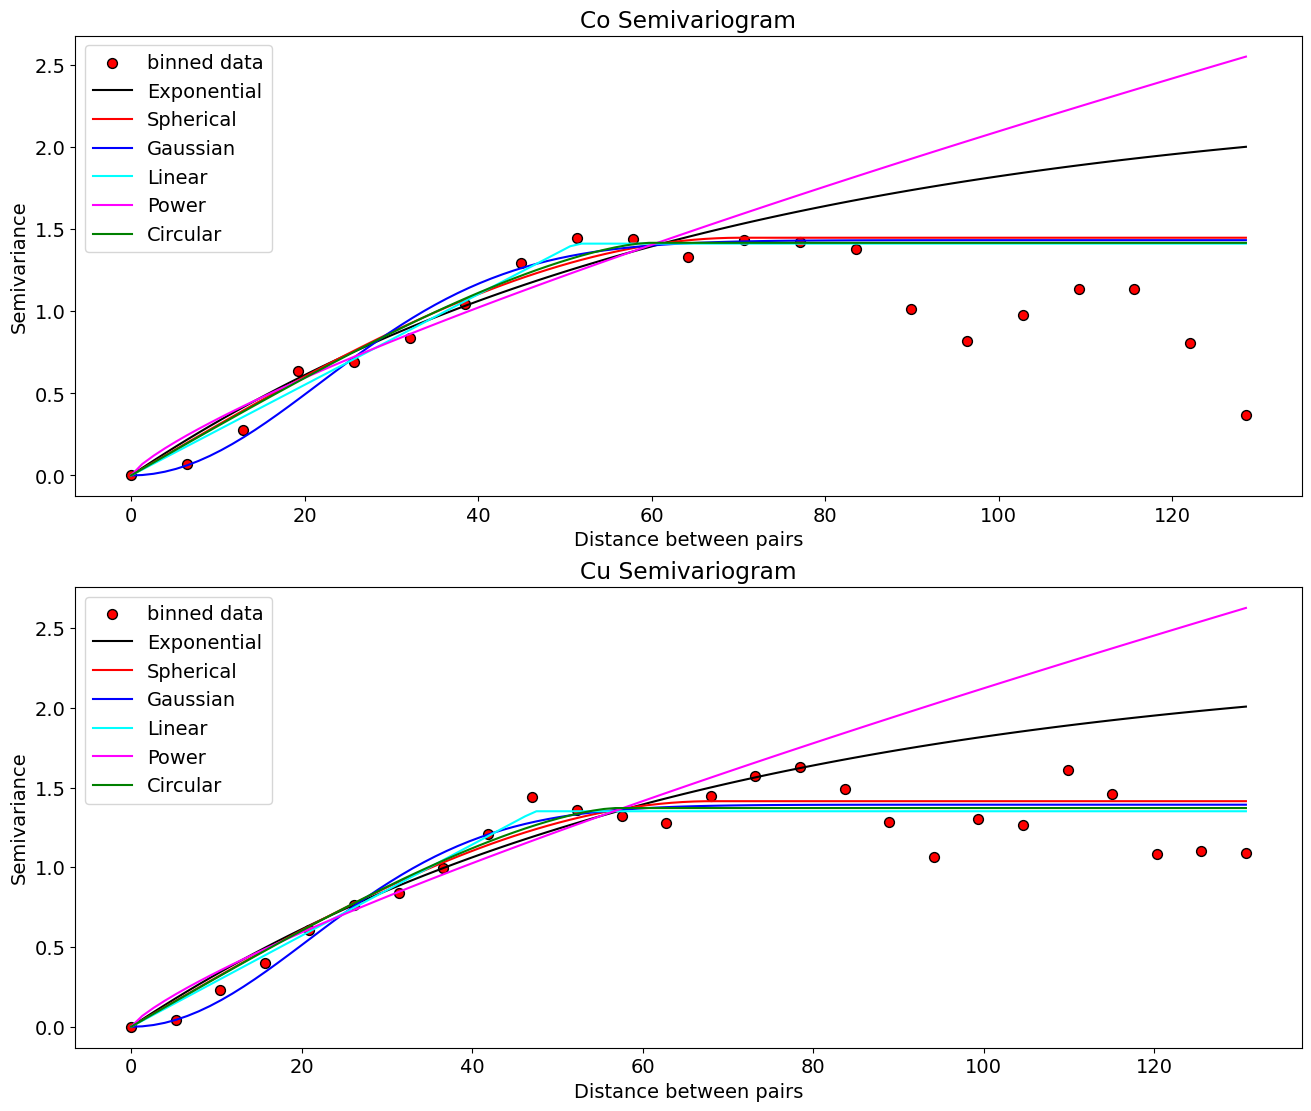

In [59]:
##############################################################################
##############################################################################
#
#   Create plots of the semivariograms for Co and Cu as well as model fits
#
##############################################################################
##############################################################################
pbins_co = np.linspace(0,hmax_co,100)
pbins_cu = np.linspace(0,hmax_cu,100)

fig,ax = plt.subplots(2,1,constrained_layout=True) 
fig.tight_layout
fig.set_size_inches(13,11)

# setting font size to 14
plt.rcParams.update({'font.size': 14})

model_colors = ['black','red','blue','cyan','magenta','green']

## Plot Cobalt semivariogram and fits
ax1 = ax[0].scatter(bins_co,Gamma_b_co,s=50,color='red',linewidths=1,edgecolors='k',label='binned data')
for i in range(len(models)):
    ax[0].plot(pbins_co,fitModel(pbins_co,models[i],fitparams_co[i,0],fitparams_co[i,1],fitparams_co[i,2]), \
               color=model_colors[i],label=models[i])
ax[0].set_xlabel('Distance between pairs')
ax[0].set_ylabel('Semivariance')
ax[0].set_title('Co Semivariogram')
ax[0].legend()

## Plot Cobalt semivariogram and fits
ax2 = ax[1].scatter(bins_cu,Gamma_b_cu,s=50,color='red',linewidths=1,edgecolors='k',label='binned data')
for i in range(len(models)):
    ax[1].plot(pbins_cu,fitModel(pbins_cu,models[i],fitparams_cu[i,0],fitparams_cu[i,1],fitparams_cu[i,2]),\
               color=model_colors[i],label=models[i])
ax[1].set_xlabel('Distance between pairs')
ax[1].set_ylabel('Semivariance')
ax[1].set_title('Cu Semivariogram')
ax[1].legend()

In [60]:
# Create a spatial grid to prediction concentration values across the field
ngrid = 100
centers = np.linspace(0,99,ngrid)+0.5
edges = np.linspace(0,100,ngrid+1)
x_i,y_i = np.meshgrid(centers,centers)
x_i = x_i.reshape(-1,1)
y_i = y_i.reshape(-1,1)
ncells =  np.size(x_i)

In [61]:
# Calculate predictions for Co and Cu concentrations at grid points using Kriging for each fit model
pred_co = np.zeros([ncells,len(models)])
pred_var_co = np.zeros([ncells,len(models)])

pred_cu = np.zeros([ncells,len(models)])
pred_var_cu = np.zeros([ncells,len(models)])

for i in range(len(models)):
    print(i)
    Mco = ConstructKrigingSystem(co_pos,co_dat,models[i],fitparams_co[i,:])
    pred_co[:,i], pred_var_co[:,i] = KrigingPrediction(co_pos,co_dat,x_i,y_i,Mco,models[i],fitparams_co[i,:])

    Mcu = ConstructKrigingSystem(cu_pos,cu_dat,models[i],fitparams_cu[i,:])
    pred_cu[:,i], pred_var_cu[:,i] = KrigingPrediction(cu_pos,cu_dat,x_i,y_i,Mcu,models[i],fitparams_cu[i,:])

0
1
2
3
4
5


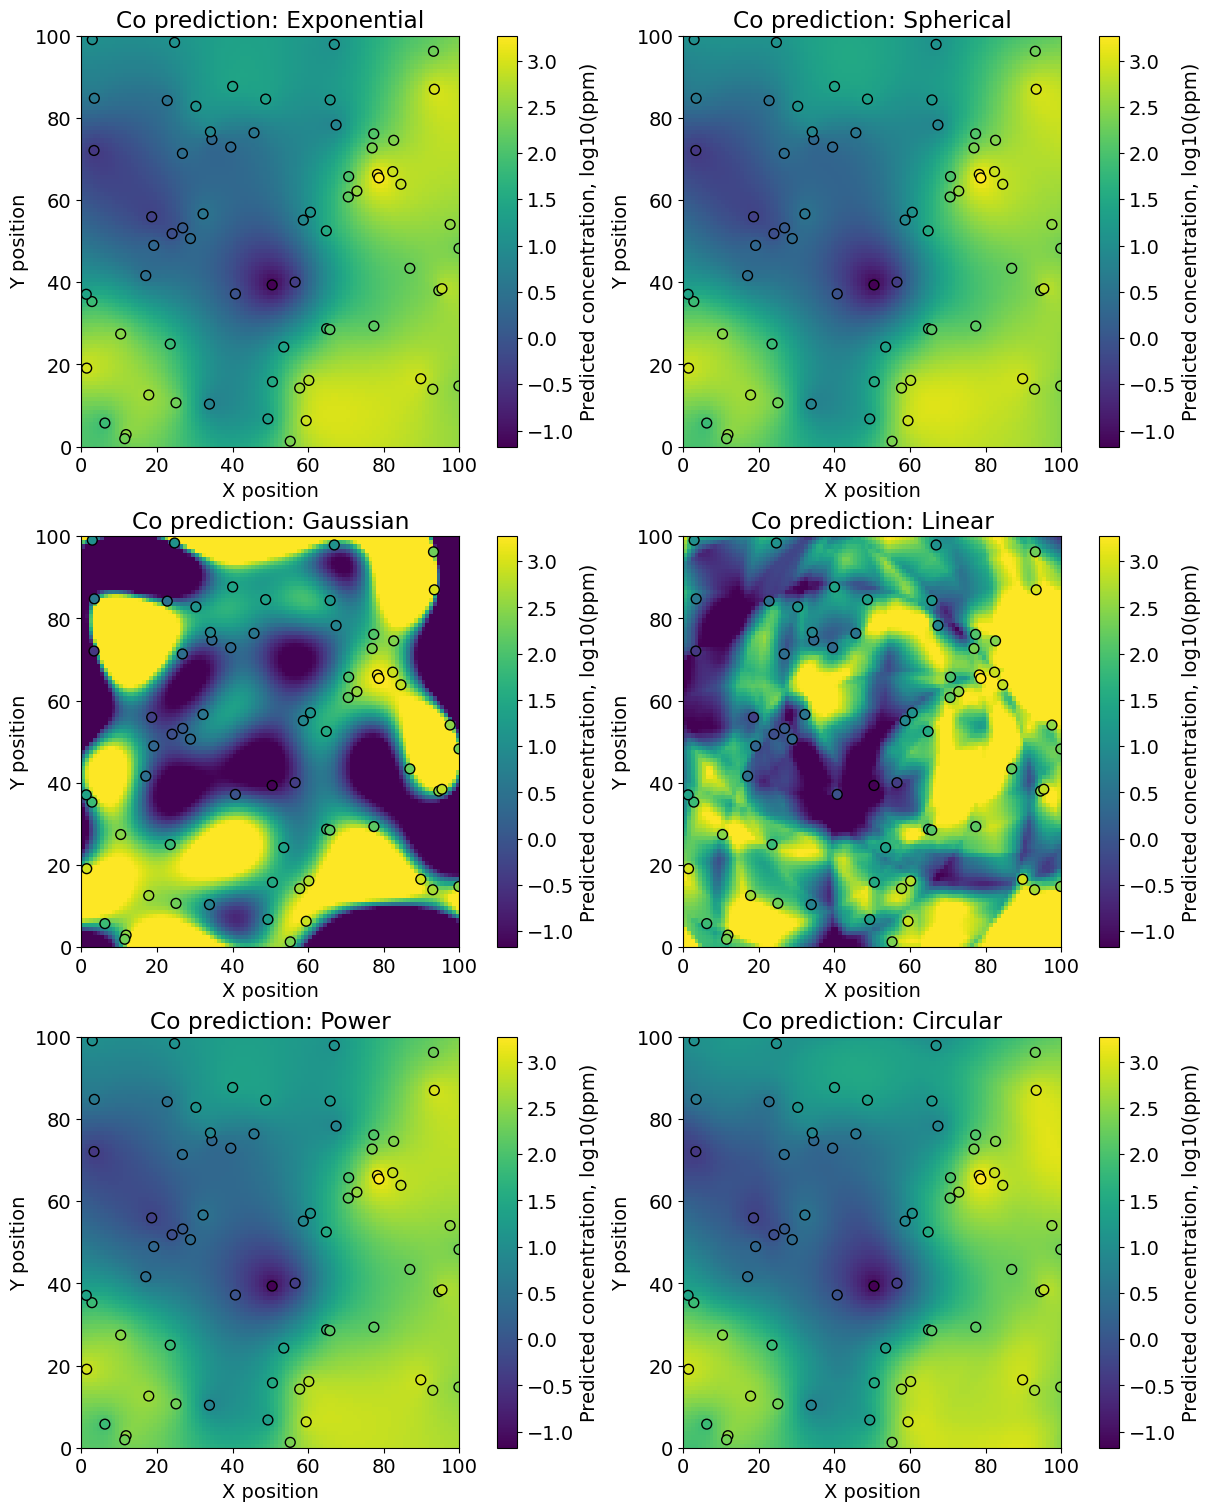

In [69]:
#     
#     Let's plot the predicted concentration maps for Cobalt using the different fit models   
# 

fig,ax = plt.subplots(3,2,constrained_layout=True) 
X_edges, Y_edges = np.meshgrid(edges, edges)
fig.tight_layout

fig.set_size_inches(12,15)
for i in range(len(models)):
    row = int(np.floor(i / 2))
    col = i % 2
    mapping = ax[row][col].pcolormesh(X_edges, Y_edges, pred_co[:,i].reshape(ngrid, ngrid),shading='flat',\
                                      vmin=np.min(co_dat+mu_co),vmax=np.max(co_dat+mu_co))
    cb = plt.colorbar(mapping,ax=ax[row][col])  
    cb.set_label('Predicted concentration, log10(ppm)')
    ax[row][col].scatter(co_pos[:,0],co_pos[:,1],s=50,c=co_dat+mu_co,linewidths=1,edgecolors='k',vmin=np.min(co_dat+mu_co),vmax=np.max(co_dat+mu_co))
    ax[row][col].set_xlabel('X position')
    ax[row][col].set_ylabel('Y position')
    ax[row][col].set_title("Co prediction: %s"%(models[i]))
    

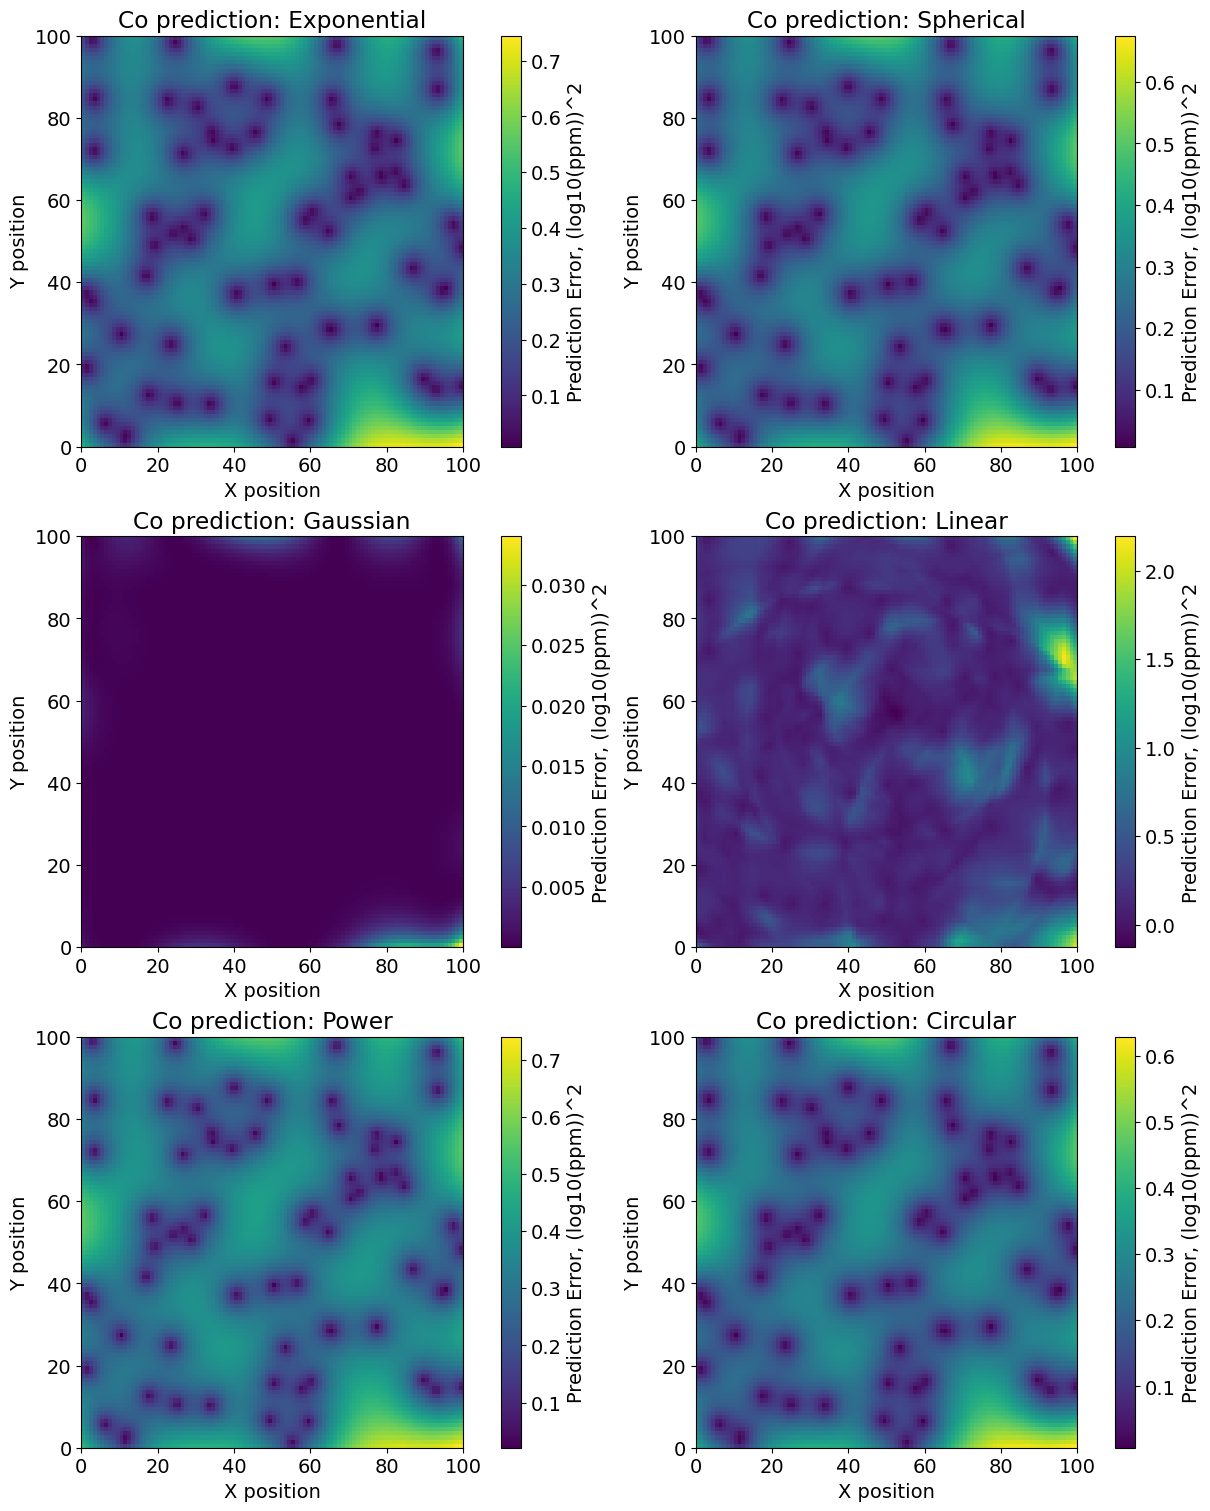

In [85]:
#     
#     We can also plot the spatial distribution of the predicted uncertainty for Co
# 
fig,ax = plt.subplots(3,2,constrained_layout=True) 
X_edges, Y_edges = np.meshgrid(edges, edges)
fig.tight_layout

fig.set_size_inches(12,15)
for i in range(len(models)):
    row = int(np.floor(i / 2))
    col = i % 2
    mapping = ax[row][col].pcolormesh(X_edges, Y_edges, pred_var_co[:,i].reshape(ngrid, ngrid),shading='flat')
    ax[row][col].set_xlabel('X position')
    ax[row][col].set_ylabel('Y position')
    ax[row][col].set_title("Co prediction: %s"%(models[i]))
    cb = plt.colorbar(mapping,ax=ax[row][col])  
    cb.set_label('Prediction Error, (log10(ppm))^2')

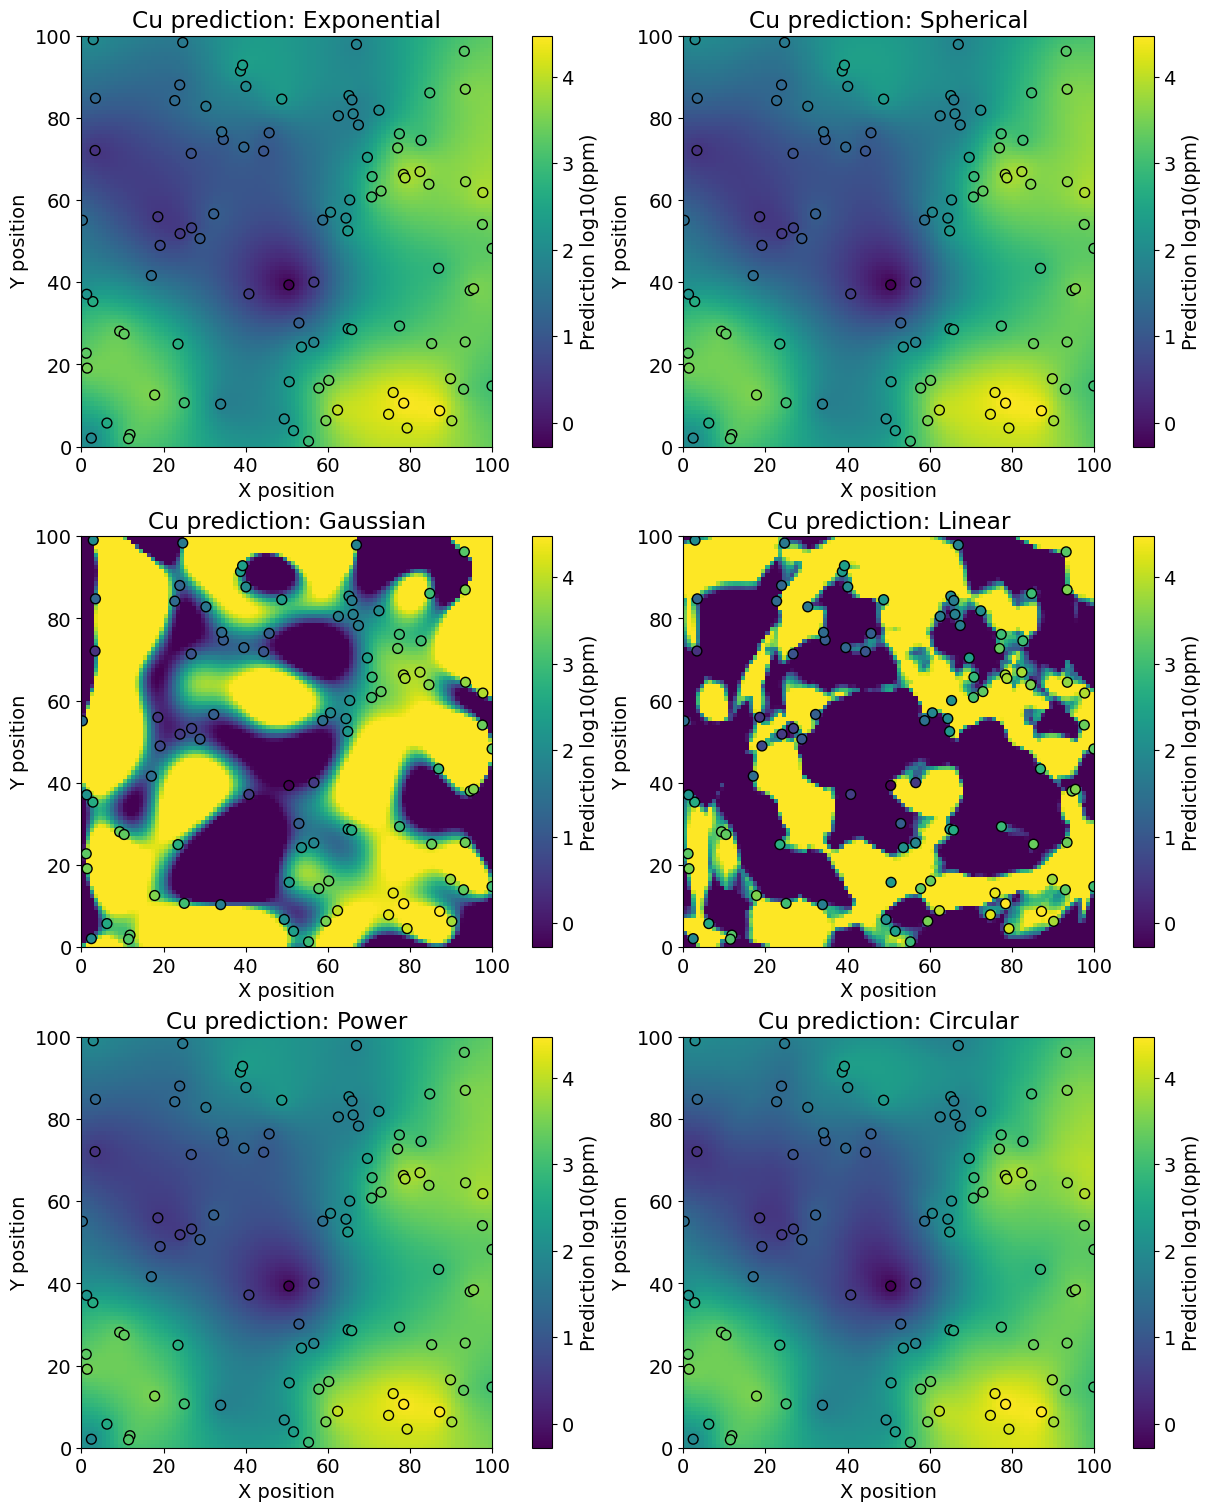

In [76]:
#     
#     Let's plot the predicted concentration maps for Copper using the different fit models   
# 
fig,ax = plt.subplots(3,2,constrained_layout=True) 
X_edges, Y_edges = np.meshgrid(edges, edges)
fig.tight_layout

fig.set_size_inches(12,15)
for i in range(len(models)):
    row = int(np.floor(i / 2))
    col = i % 2
    mapping = ax[row][col].pcolormesh(X_edges, Y_edges, pred_cu[:,i].reshape(ngrid, ngrid),shading='flat',\
                                      vmin=np.min(cu_dat+mu_cu),vmax=np.max(cu_dat+mu_cu))
    ax[row][col].scatter(cu_pos[:,0],cu_pos[:,1],s=50,c=cu_dat+mu_cu,linewidths=1,edgecolors='k',\
                                      vmin=np.min(cu_dat+mu_cu),vmax=np.max(cu_dat+mu_cu))
    ax[row][col].set_xlabel('X position')
    ax[row][col].set_ylabel('Y position')
    ax[row][col].set_title("Cu prediction: %s"%(models[i]))
    cb = plt.colorbar(mapping,ax=ax[row][col])  
#    cb.set_label('Prediction log10(ppm)')

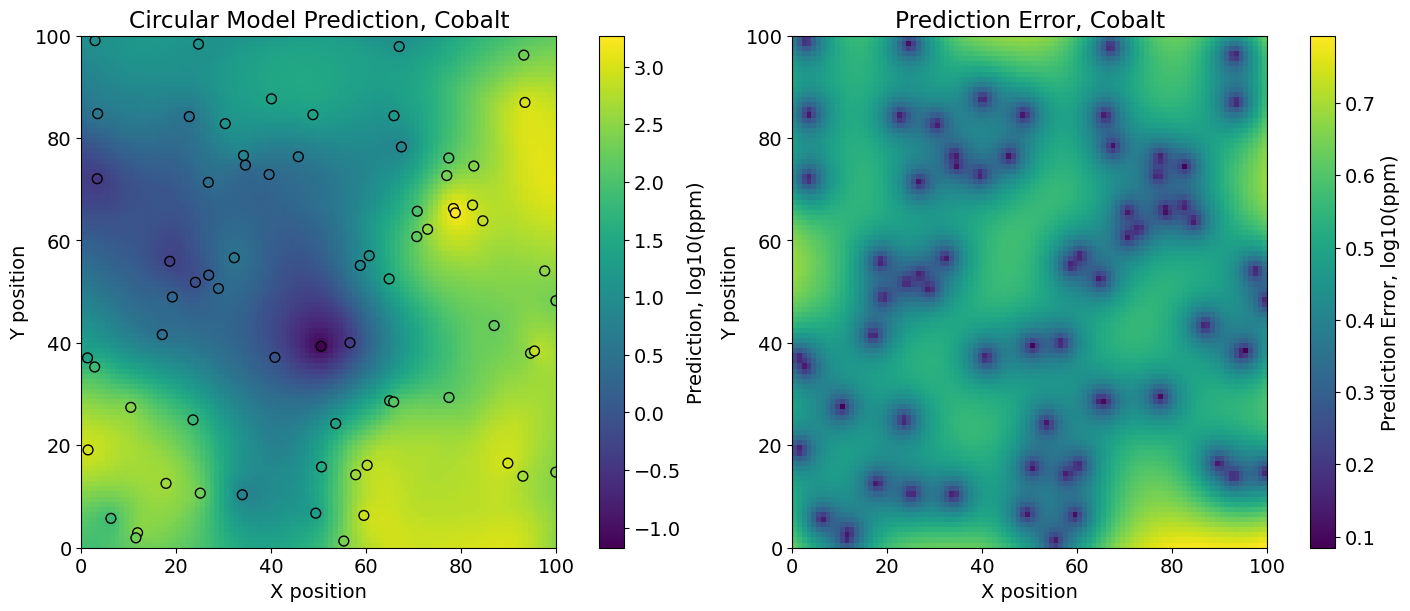

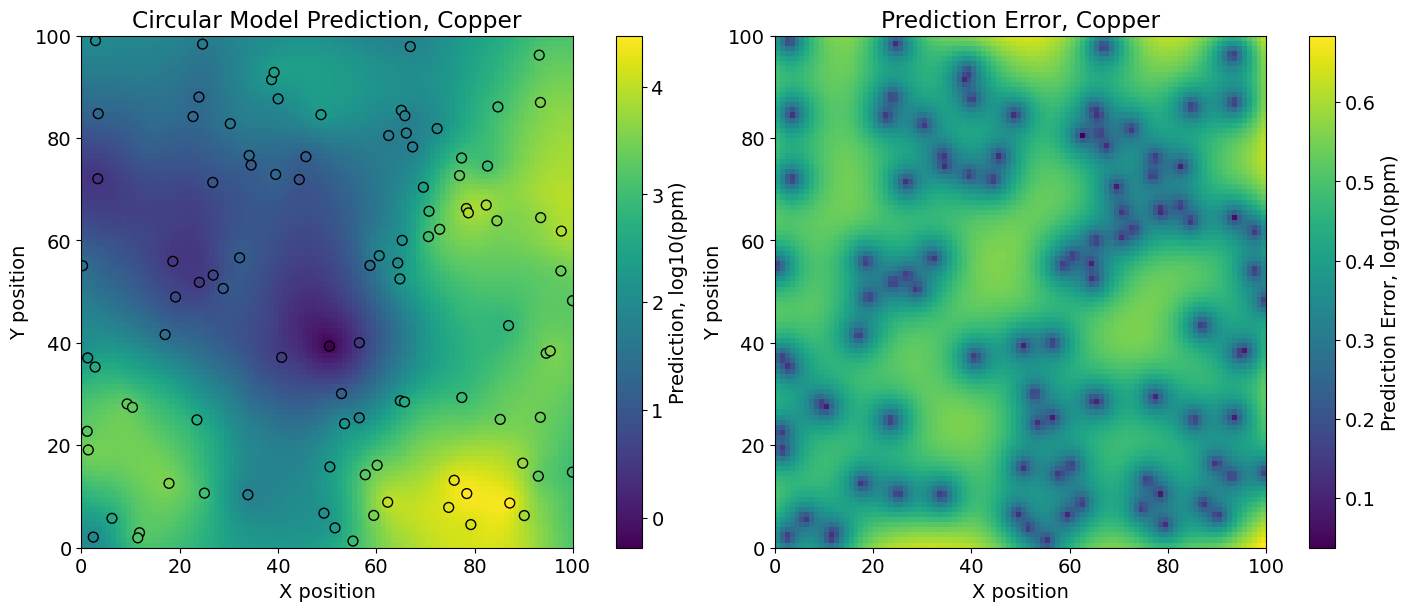

In [107]:
#
#    From the tables above it appears that the Gaussian and Linear fits best reduced the variance with the
#    binned experimental semivariograms for copper and cobalt
#    => However the interpolated prediction looks question beyond the sampled points (need to review)
#    
#    The spatial interpolations using the exponential, spherical, power law, and circular fit models are qualitatively similar
#    => Let us select the prediction using the circular fit model, which has the next smallest fit error

#    Here we plot the predictions for Co and Cu concentrations, along with the prediction uncertainties

fig,ax = plt.subplots(1,2,constrained_layout=True) 
X_edges, Y_edges = np.meshgrid(edges, edges)
fig.tight_layout

fig.set_size_inches(14,6)

mapping = ax[0].pcolormesh(X_edges, Y_edges, pred_co[:,-1].reshape(ngrid, ngrid),shading='flat',\
                                      vmin=np.min(co_dat+mu_co),vmax=np.max(co_dat+mu_co))
cb = plt.colorbar(mapping,ax=ax[0])  
cb.set_label('Prediction, log10(ppm)')
ax[0].scatter(co_pos[:,0],co_pos[:,1],s=50,c=co_dat+mu_co,linewidths=1,edgecolors='k',\
                 vmin=np.min(co_dat+mu_co),vmax=np.max(co_dat+mu_co))
ax[0].set_xlabel('X position')
ax[0].set_ylabel('Y position')
ax[0].set_title('Circular Model Prediction, Cobalt')

mapping2 = ax[1].pcolormesh(X_edges, Y_edges, np.sqrt(pred_var_co[:,-1]).reshape(ngrid, ngrid),shading='flat')
ax[1].set_xlabel('X position')
ax[1].set_ylabel('Y position')
ax[1].set_title('Prediction Error, Cobalt')
cb2 = plt.colorbar(mapping2,ax=ax[1])  
cb2.set_label('Prediction Error, log10(ppm)')
fig.savefig('Co_predictions.png')


fig2,ax2 = plt.subplots(1,2,constrained_layout=True) 
fig2.tight_layout
fig2.set_size_inches(14,6)

mapping3 = ax2[0].pcolormesh(X_edges, Y_edges, pred_cu[:,-1].reshape(ngrid, ngrid),shading='flat',\
                                      vmin=np.min(cu_dat+mu_cu),vmax=np.max(cu_dat+mu_cu))
ax2[0].scatter(cu_pos[:,0],cu_pos[:,1],s=50,c=cu_dat+mu_cu,linewidths=1,edgecolors='k',\
                                      vmin=np.min(cu_dat+mu_cu),vmax=np.max(cu_dat+mu_cu))
ax2[0].set_xlabel('X position')
ax2[0].set_ylabel('Y position')
ax2[0].set_title('Circular Model Prediction, Copper')
cb3 = plt.colorbar(mapping3,ax=ax2[0])  
cb3.set_label('Prediction, log10(ppm)')

mapping4 = ax2[1].pcolormesh(X_edges, Y_edges, np.sqrt(pred_var_cu[:,-1]).reshape(ngrid, ngrid),shading='flat')
ax2[1].set_xlabel('X position')
ax2[1].set_ylabel('Y position')
ax2[1].set_title('Prediction Error, Copper')
cb4 = plt.colorbar(mapping4,ax=ax2[1])  
cb4.set_label('Prediction Error, log10(ppm)')
fig2.savefig('Cu_predictions.png')

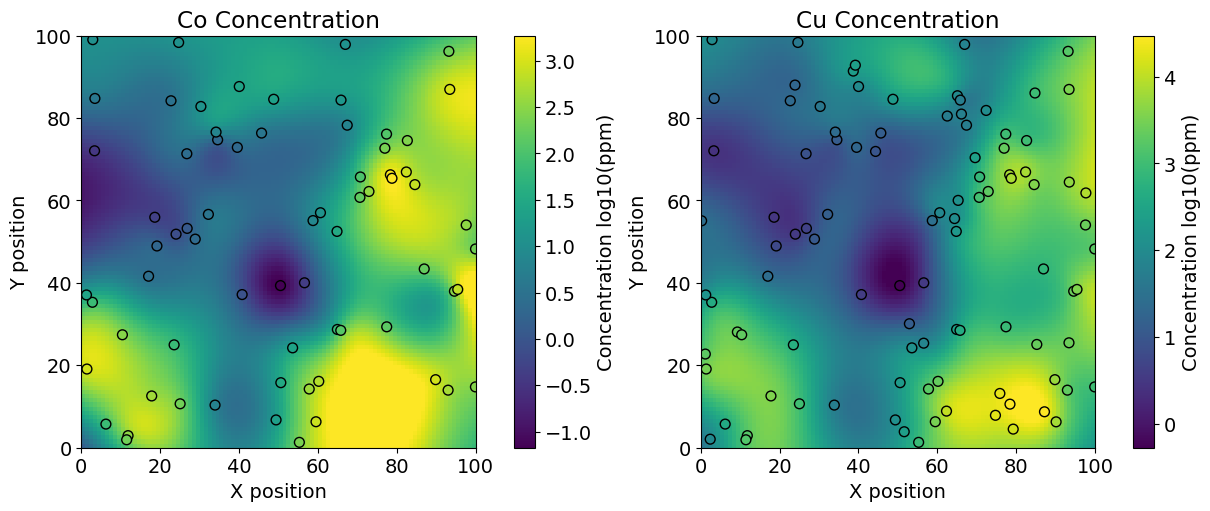

In [82]:
"""

Let's do a quick comparison with interpolation using radial basis functions
=> A good deal of qualitative similarity

"""
kern = 'cubic'
rbflco = RBFInterpolator(co_pos,np.log10(co_con),epsilon=2,kernel=kern)
rbflcu = RBFInterpolator(cu_pos,np.log10(cu_con),epsilon=2,kernel=kern)

xy_i = np.concatenate([x_i, y_i],axis=1)
z_ico = rbflco(xy_i)
z_icu = rbflcu(xy_i)

fig,ax = plt.subplots(1,2,constrained_layout=True) 
fig.tight_layout
fig.set_size_inches(12,5)

mapping = ax[0].pcolormesh(
    X_edges, Y_edges, z_ico.reshape(ngrid, ngrid),
    shading='flat',vmin=np.min(co_dat+mu_co),vmax=np.max(co_dat+mu_co))
ax[0].scatter(co_pos[:,0],co_pos[:,1],s=50,c=np.log10(co_con),linewidths=1,edgecolors='k',\
              vmin=np.min(co_dat+mu_co),vmax=np.max(co_dat+mu_co))
ax[0].set_xlabel('X position')
ax[0].set_ylabel('Y position')
ax[0].set_title('Co Concentration')
cb1 = plt.colorbar(mapping,ax=ax[0])  
cb1.set_label('Concentration log10(ppm)')


mappingl = ax[1].pcolormesh(
    X_edges, Y_edges, z_icu.reshape(ngrid, ngrid),
    shading='flat',vmin=np.min(cu_dat+mu_cu),vmax=np.max(cu_dat+mu_cu))
ax[1].scatter(cu_pos[:,0],cu_pos[:,1],s=50,c=np.log10(cu_con),linewidths=1,edgecolors='k',\
              vmin=np.min(cu_dat+mu_cu),vmax=np.max(cu_dat+mu_cu))
ax[1].set_xlabel('X position')
ax[1].set_ylabel('Y position')
ax[1].set_title('Cu Concentration')
cb2 = plt.colorbar(mappingl,ax=ax[1])  
cb2.set_label('Concentration log10(ppm)')